In [215]:
from sklearn import metrics

In [216]:
y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]
print('Precision: {:.2f}'.format(metrics.precision_score(y_true, y_pred)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_true, y_pred)))
print('F1: {:.2f}'.format(metrics.f1_score(y_true, y_pred)))

Precision: 0.75
Recall: 0.60
F1: 0.67




Для практики будем решать задачу оттока клиентов из банка. 
Скачать данные

Вы уже знакомились с этой задачей в модуле по визуализации и провели небольшое исследование данных. В этом модуле мы построим классификатор, который позволит своевременно определять уходящих клиентов банка.

Для начала импортируем библиотеки, которые нам понадобятся:

In [217]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

/tmp/ipykernel_13550/2408503256.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Итак, прочитаем нашу таблицу:

In [218]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0




Напомним значения столбцов:

        RowNumber — номер строки таблицы;
        CustomerId — идентификатор клиента;
        Surname — фамилия клиента;
        CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
        Geography — страна проживания клиента (банк межнациональный);
        Gender — пол клиента;
        Age — возраст клиента;
        Tenure — сколько лет клиент пользуется банком;
        Balance — сколько у клиента денег на счетах в банке;
        NumOfProduct — число услуг банка, которые приобрёл клиент;
        HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
        IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
        EstimatedSalary — предполагаемая заработная плата клиента;
        Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [219]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape
# (2509, 14)


(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [220]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [221]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64



Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

        BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
        TenureByAge — отношение времени пользования банком к возрасту клиента;
        CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.


In [222]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [223]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [224]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

И, наконец, заранее позаботимся о масштабах признаков. Проведём нормализацию матрицы наблюдений X:

In [225]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [226]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64



Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %. 

В чём может быть проблема? 

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным. 

Как хорошо, что функция train_test_split() из библиотеки sklearn умеет производить такое разбиение! Для этого в функции предусмотрен параметр stratify, который нужно выставить в значение признака. Признак должен иметь одинаковые соотношения в тренировочной и тестовой выборках. У нас этим признаком является целевой признак y.

Выполним разбиение, установив значением параметра random_state число 0:

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Train shape: (1881, 12)
# Test shape: (628, 12)

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [228]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


Соотношения одинаковы. А значит, мы можем приступить к заданиям ↓

Задание 4.2

Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [229]:
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42
)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

#Рассчитываем F1-меру
print('F1 train score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 test score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 train score: 0.49
F1 test score: 0.47


Задание 4.3

Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Чему равно количество признаков в тренировочной выборке?

In [230]:
from sklearn.preprocessing import PolynomialFeatures

In [231]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print(f'X_train_poly shape {X_train_poly.shape}')

X_train_poly shape (1881, 454)


Задание 4.4

Обучите модель логистической регрессии на полиномиальных признаках.

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [232]:
log_reg_poly = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg_poly.fit(X_train_poly, y_train)

y_train_poly = log_reg_poly.predict(X_train_poly)
y_test_poly = log_reg_poly.predict(X_test_poly)

#Рассчитываем F1-меру
print('F1 train score: {:.2f}'.format(metrics.f1_score(y_train, y_train_poly)))
print('F1 test score: {:.2f}'.format(metrics.f1_score(y_test, y_test_poly)))

F1 train score: 0.66
F1 test score: 0.64


Задание 4.5

Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

В качестве порога вероятности используйте значения из следующего диапазона:

In [233]:
thresholds = np.arange(0.1, 1, 0.05)

Напомним алгоритм, как определить оптимальный порог вероятности:

    Предсказать вероятности оттока для каждого клиента из тестовой выборки.
    В цикле перебирать значения порогов вероятности threshold: сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0. Далее рассчитать метрику и занести её в заранее созданный список.

Постройте график зависимости целевой метрики от порога вероятности.

Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ приведите с точностью до двух знаков после точки-разделителя.

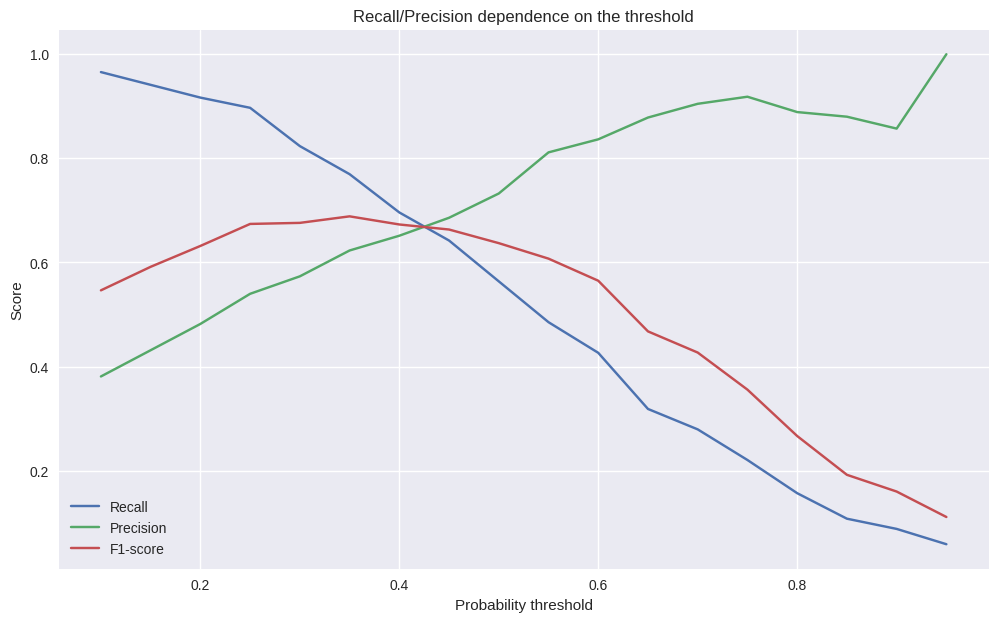

In [234]:
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
recall_scores = []
precision_scores = []
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')

ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

Задание 4.6

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [235]:
y_test_proba_pred

0      0.317623
1      0.525636
2      0.054858
3      0.100573
4      0.473225
         ...   
623    0.208425
624    0.418402
625    0.200336
626    0.141032
627    0.075169
Length: 628, dtype: float64

In [236]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(round(metrics.f1_score(y_test, y_test_pred_opt), 2))

0.69


Задание 6.5

Скачайте набор данных о винах. Вам необходимо будет предсказать качество вина по его характеристикам.

Для начала подготовим данные к бинарной классификации. Условно разделим вино на хорошее и плохое. Хорошим вином будем называть вино, параметр quality которого 6, плохим — всё остальное.



In [237]:
wine_data = pd.read_csv('data/winequality-red.csv', sep=';')
wine_data['quality'] = wine_data['quality'].apply(lambda x: 1 if x>=6 else 0)
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

Затем разделим выборку на тренировочную и тестовую:

In [238]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Обучите на тренировочной выборке (X_train, y_train) модель случайного леса, состоящего из 500 деревьев. Максимальная глубина каждого из деревьев — 8. Минимальное число объектов в листе — 10. В качестве критерия информативности используйте критерий Джини. Количество признаков, на которых обучается каждое из деревьев, возьмите как

, где — общее количество признаков. В качестве значения параметра random_state возьмите число 42.

Сделайте предсказание качества вина для тренировочного и тестового наборов данных.

Рассчитайте метрику accuracy для каждого набора и запишите её в качестве ответа с точностью до двух знаков после точки-разделителя.

In [239]:
from sklearn import ensemble
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=8,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42
)

rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       603
           1       0.87      0.84      0.85       676

    accuracy                           0.85      1279
   macro avg       0.85      0.85      0.85      1279
weighted avg       0.85      0.85      0.85      1279

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       141
           1       0.79      0.75      0.77       179

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



Примечание. Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:

        выделить данные, относящиеся к отделениям банка в Германии;
        избавиться от заведомо неинформативных признаков;
        расширить датасет путем добавления новых признаков;
        разделить выборку на тренировочную и тестовую со стратификацией.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

→ Теперь попробуем решить задачу с помощью деревьев решений и лесов.

Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.

Поэтому для решения задачи используйте обучающую (X_train, y_train) и тестовую (X_test, y_test) выборки без полиномиальных столбцов.

In [240]:
df = pd.read_csv('data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We will leave only data related to Germany

In [241]:
df = df[df['Geography'] == 'Germany']
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
15,16,15643966,Goforth,616,Germany,Male,45,3,143129.41,2,0,1,64327.26,0
16,17,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1
26,27,15736816,Young,756,Germany,Male,36,2,136815.64,1,1,1,170041.95,0
28,29,15728693,McWilliams,574,Germany,Female,43,3,141349.43,1,1,1,100187.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,9983,15768163,Griffin,655,Germany,Female,46,7,137145.12,1,1,0,115146.40,1
9984,9985,15696175,Echezonachukwu,602,Germany,Male,35,7,90602.42,2,1,1,51695.41,0
9986,9987,15581736,Bartlett,673,Germany,Male,47,1,183579.54,2,0,1,34047.54,0
9990,9991,15798964,Nkemakonam,714,Germany,Male,33,3,35016.60,1,1,0,53667.08,0


Now let's see if there are any missing values

In [242]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

We need to check if classes are balanced

<AxesSubplot: xlabel='Exited', ylabel='count'>

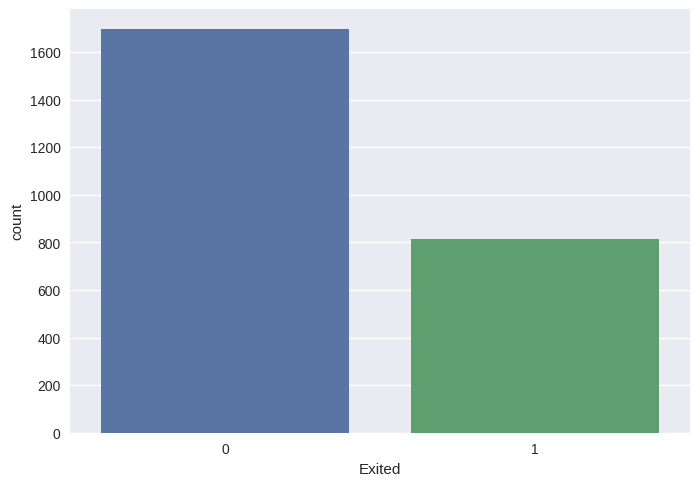

In [243]:
sns.countplot(df, x='Exited')

We can change feature 'Gender' by appointing 0 for Male and 1 for Female

In [244]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

Deleting unnecessary features

In [245]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1)

In [246]:
df = df.reset_index(drop=True)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,376,1,29,4,115046.74,4,1,0,119346.88,1
1,616,0,45,3,143129.41,2,0,1,64327.26,0
2,653,0,58,1,132602.88,1,1,0,5097.67,1
3,756,0,36,2,136815.64,1,1,1,170041.95,0
4,574,1,43,3,141349.43,1,1,1,100187.43,0


<AxesSubplot: >

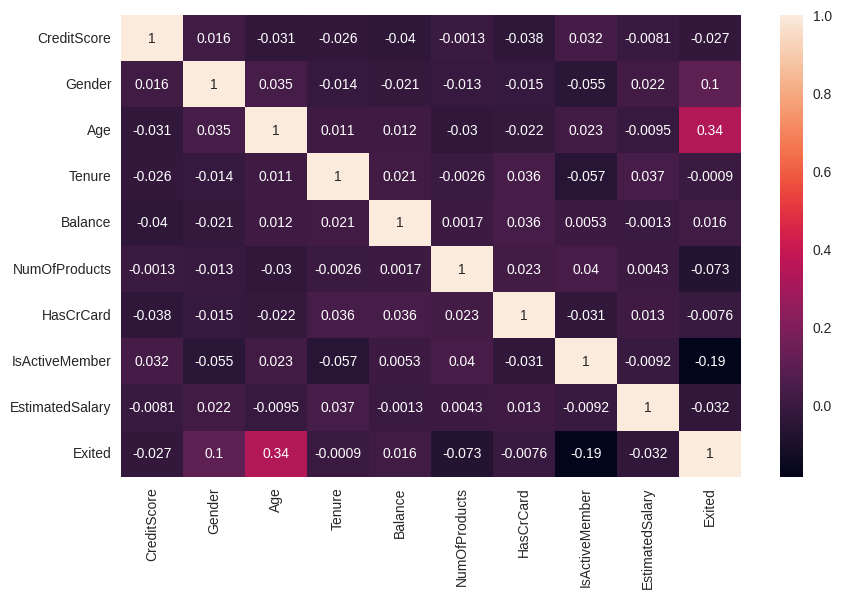

In [247]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True)

We have to create matrix of features X and vector of correct answers y

In [248]:
y = df['Exited']
X = df.drop(columns='Exited', axis=1)

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = 0)

In [250]:
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики

In [251]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42    
)
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

print(f'F1 score train: {round(metrics.f1_score(y_train, y_train_pred), 2)}')
print(f'F1 score test: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

F1 score train: 0.72
F1 score test: 0.68


Задание 7.2

Постройте случайный лес из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона. Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Сделайте предсказания для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?

In [252]:
rand_forest = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_split=10,
    random_state=42
)

rand_forest.fit(X_train, y_train)

y_train_pred_rf = rand_forest.predict(X_train)
y_test_pred_rf = rand_forest.predict(X_test)


print(f'F1 score train: {round(metrics.f1_score(y_train, y_train_pred_rf), 2)}')
print(f'F1 score test: {round(metrics.f1_score(y_test, y_test_pred_rf), 2)}')

F1 score train: 0.75
F1 score test: 0.62


/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


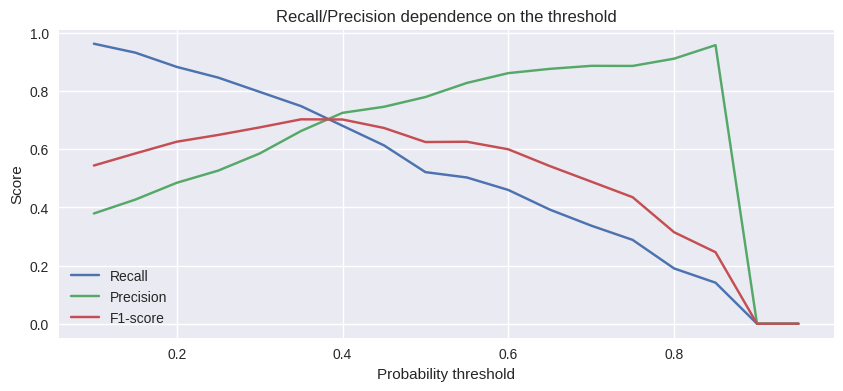

In [253]:

y_test_proba_pred = rand_forest.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность ухода > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [255]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность ухода больше 0.35 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))
print(f'F1 score test: {round(metrics.f1_score(y_test, y_test_pred_opt), 2)}')

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       339
           1       0.66      0.75      0.70       163

    accuracy                           0.79       502
   macro avg       0.77      0.78      0.77       502
weighted avg       0.80      0.79      0.80       502

F1 score test: 0.7
